In [ ]:
# utils functions

import pathlib
import shutil
import os
import time
import datetime 
import numpy as np
import wandb
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile

from typing import List

def load_data(run, artifact_name = "phcd_paper_splits_tfds") -> List[tf.data.Dataset]:
    """
    Downloads datasets from a wandb artifact and loads them into a list of tf.data.Datasets.
    """

    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = pathlib.Path(
        f"./artifacts/{artifact.name.replace(':', '-')}"
    ).resolve()
    if not artifact_dir.exists():
        artifact_dir = artifact.download()
        artifact_dir = pathlib.Path(artifact_dir).resolve()

    # if tf.__version__ minor is less than 10, use
    # tf.data.experimental.load instead of tf.data.Dataset.load

    if int(tf.__version__.split(".")[1]) < 10:
        load_function = tf.data.experimental.load
    else:
        load_function = tf.data.Dataset.load
    
    output_list = []
    for split in ["train", "test", "val"]:
        ds = load_function(str(artifact_dir / split), compression="GZIP")
        output_list.append(ds)
    
    return output_list

def get_readable_class_labels(subset = 'phcd_paper'):
    if subset == 'phcd_paper':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c',
        'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C',
        'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
        'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'ą', 'ć', 'ę',
        'ł', 'ń', 'ó', 'ś', 'ź', 'ż', 'Ą', 'Ć', 'Ę', 'Ł', 'Ń', 'Ó', 'Ś',
        'Ź', 'Ż', '+', '-', ':', ';', '$', '!', '?', '@', '.']
    elif subset == 'uppercase':
        return ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Ą', 'Ć', 
        'Ę', 'Ł', 'Ń', 'Ó', 'Ś', 'Ź', 'Ż']
    elif subset == 'lowercase':
        return ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ą', 'ć',
        'ę', 'ł', 'ń', 'ó', 'ś', 'ź', 'ż']
    elif subset == 'numbers':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    elif subset == 'uppercase_no_diacritics':
        return ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    elif subset == 'lowercase_no_diacritics':
        return ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

def calculate_accuracy_per_class(model, test_dataset, test_dataset_name):
    '''
    Calculates the accuracy per class for a given model and test dataset.

    Returns dict with class labels as keys and accuracy as values.
    '''
        
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)
    # get labels
    y_true = test_dataset.map(lambda x, y: y).as_numpy_iterator()
    y_true = np.concatenate(list(y_true))
    # calculate accuracy per class
    labels = get_readable_class_labels(test_dataset_name)
    class_accuracy = np.zeros(len(labels))
    for i, label in enumerate(labels):
        class_accuracy[i] = np.sum(y_pred[y_true == i] == i) / np.sum(y_true == i)
    return { label: acc for label, acc in zip(labels, class_accuracy) }
    

def plot_accuracy_per_class(class_accuracy_dict):
    plt.figure(figsize=(10, 5))
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    plt.bar(labels, class_accuracy)
    plt.xticks(labels)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per class")
    plt.show()


def accuracy_table(class_accuracy_dict):
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    return wandb.Table(columns=["Class", "Accuracy"], data=list(zip(labels, class_accuracy)))

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    labels_iterator= ds.map(lambda x, y: y).as_numpy_iterator()
    labels = np.concatenate(list(labels_iterator))
    return len(np.unique(labels))

def get_number_of_examples(ds: tf.data.Dataset) -> int:
    """
    Returns the number of examples in a dataset.
    """
    return sum(1 for _ in ds)

def preprocess_dataset(ds: tf.data.Dataset, batch_size: int, cache: bool = True) -> tf.data.Dataset:
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
    ds = ds.unbatch().batch(batch_size)
    if cache:
        ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def calculate_model_compressed_size_on_disk(path: str) -> int:
    compressed_path = path + ".zip"
    with zipfile.ZipFile(compressed_path, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(path)
    return pathlib.Path(compressed_path).stat().st_size    

def calculate_model_size_on_disk(path: str) -> int:
    return pathlib.Path(path).stat().st_size

def calculate_model_num_parameters(model: tf.keras.Model) -> int:
    return model.count_params()

def calculate_model_flops(summary) -> float:
    # from run.summary get GFLOPs or GFLOPS whichever is available
    if "GFLOPs" in summary.keys():
        return summary.get("GFLOPs")
    elif "GFLOPS" in summary.keys():
        return summary.get("GFLOPS")
    else:
        return 0
    
def plot_history(history, title):
    plt.figure(figsize=(15,7))
    plt.suptitle(title)
    
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

wandb:   9 of 9 files downloaded.  


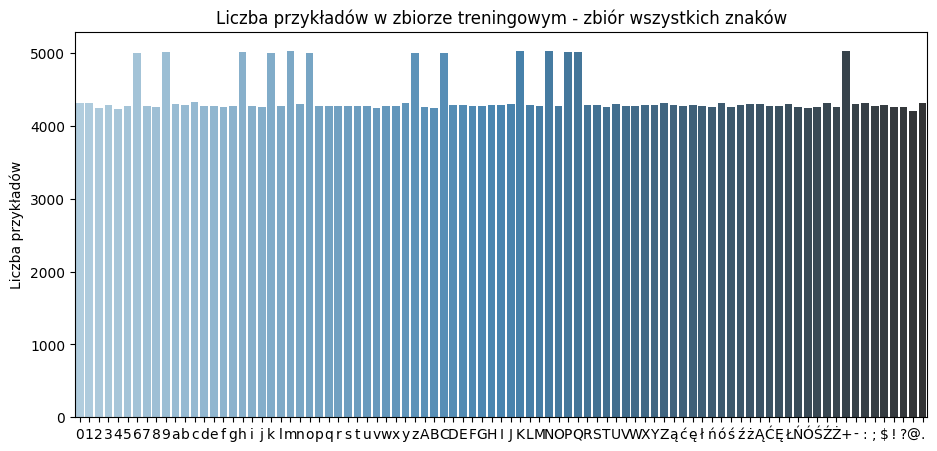

wandb: Downloading large artifact uppercase_splits_tfds:latest, 175.89MB. 21 files... 
wandb:   21 of 21 files downloaded.  
Done. 0:0:0.0


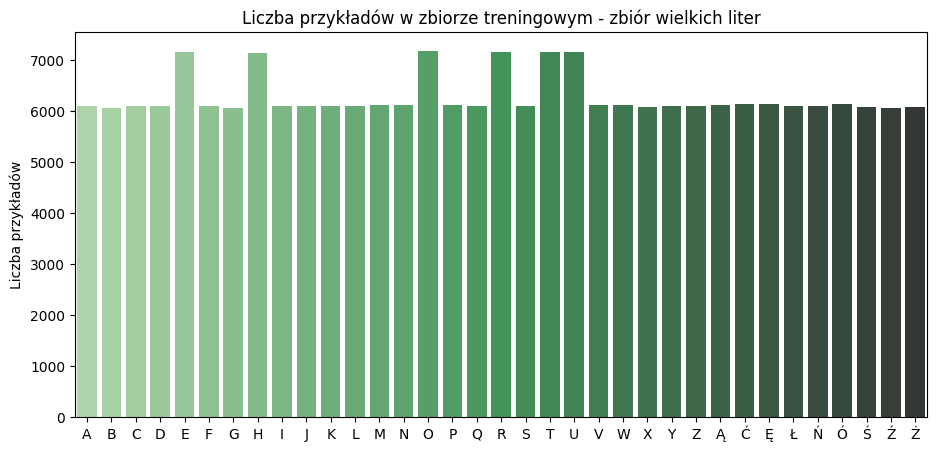

wandb: Downloading large artifact lowercase_splits_tfds:latest, 119.11MB. 15 files... 
wandb:   15 of 15 files downloaded.  
Done. 0:0:0.0


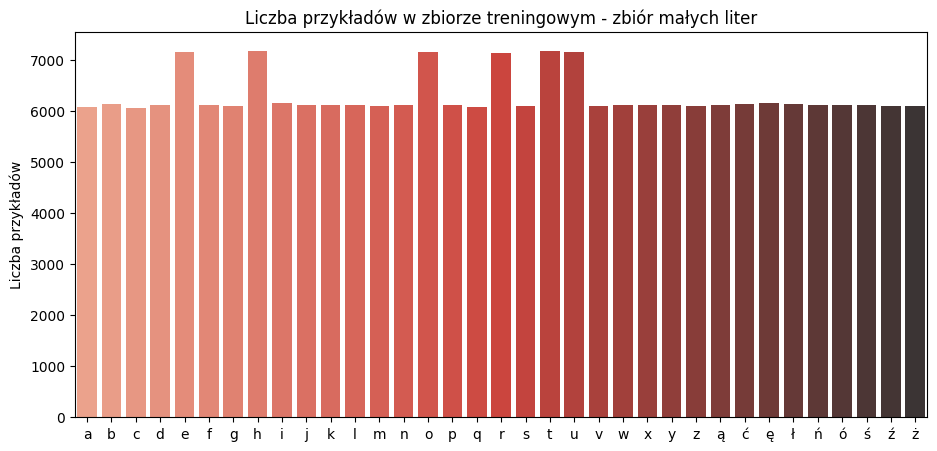

wandb: Downloading large artifact lowercase_no_diacritics_splits_tfds:latest, 139.03MB. 18 files... 
wandb:   18 of 18 files downloaded.  
Done. 0:0:1.1


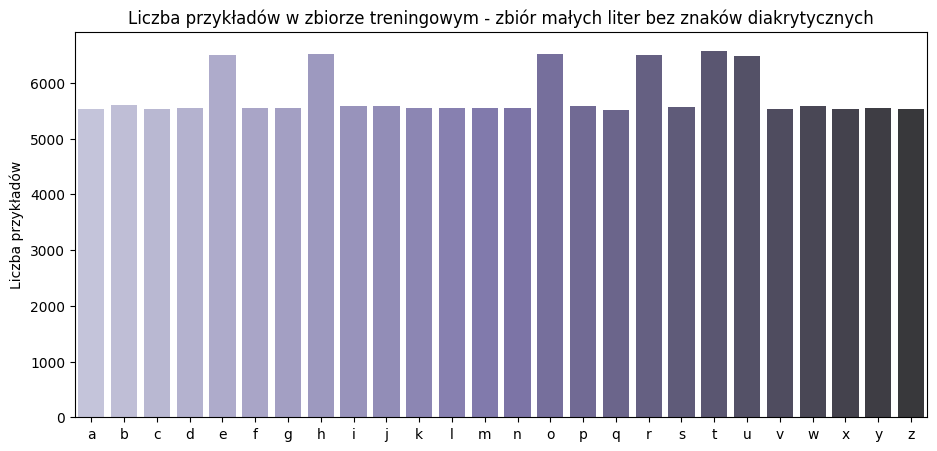

In [23]:
import seaborn as sns

defaults = dict(
    batch_size=32*2,
    epochs=60,    
    optimizer="adam"
)
run = wandb.init(project="master-thesis", job_type="junk",  config=defaults, tags=["optimization"])
# hyperparameters
epochs = wandb.config.epochs
bs = wandb.config.batch_size


artifacts = ["phcd_paper", "uppercase", "lowercase", "lowercase_no_diacritics"]
readable_ds_dict = { 
    "phcd_paper": "zbiór wszystkich znaków",
    "uppercase": "zbiór wielkich liter",
    "lowercase": "zbiór małych liter",
    "lowercase_no_diacritics": "zbiór małych liter bez znaków diakrytycznych"
}
palettes = [
    "Blues_d",
    "Greens_d",
    "Reds_d",
    "Purples_d"
]
for i, artifact_base_name in enumerate(artifacts):
    #artifact_base_name = "phcd_paper"
    artifact_name = f"{artifact_base_name}_splits_tfds" # "phcd_paper_splits_tfds

    class_labels = get_readable_class_labels(artifact_base_name)

    ds_train, ds_test, ds_val = load_data(run, artifact_name=artifact_name)

    num_classes = get_number_of_classes(ds_val)

    ds_train = preprocess_dataset(ds_train, batch_size=1, cache=False)


    # count number of examples for each class in ds_train. There are num_classes classes
    class_counts = np.zeros(num_classes)
    for x, y in ds_train:
        for label in y:
            class_counts[label] += 1

    set_name = readable_ds_dict[artifact_base_name]
    readable_class_labels = get_readable_class_labels(artifact_base_name)
    # plot class counts
    fig, ax = plt.subplots(figsize=(11, 5))

    # using seaborn
    sns.barplot(x=np.arange(num_classes), y=class_counts, ax=ax, palette=palettes[i])
    title = f"Liczba przykładów w zbiorze treningowym - {set_name}"
    ax.set_title(title)
    ax.set_ylabel("Liczba przykładów")
    # set xticks readable_class_labels
    ax.set_xticklabels(readable_class_labels)

    # save this figure as png with title as filename

    fig.savefig(f"{'_'.join(title.split(" "))}.png")
    plt.show()

In [24]:
run.finish()